In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision
import matplotlib.pyplot as plt


torch.cuda.is_available()

True

In [2]:
celeba_train = torchvision.datasets.CelebA(root="data/", split="train", target_type='identity', download=True, transform=torchvision.transforms.ToTensor())
celeba_valid = torchvision.datasets.CelebA(root="data/", split="valid", target_type='identity', download=True, transform=torchvision.transforms.ToTensor())
# celeba_test = torchvision.datasets.CelebA(root="data/", split="test", download=True)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
max(celeba_train.identity), min(celeba_train.identity)

(tensor([10177]), tensor([1]))

In [48]:
# Create np array where identity is the index to an array of all indexes of images of that identity

def create_identity_array(dataset):
    identity_array = np.empty(max(dataset.identity)+1, dtype=object)
    for i, id in enumerate(dataset.identity):
        if identity_array[id] is None:
            identity_array[id] = np.array([i])
        else:
            identity_array[id] = np.append(identity_array[id], i)
            
    return identity_array
    
# identity_idx_train = create_identity_array(celeba_train)
# identity_idx_valid = create_identity_array(celeba_valid)
# identity_map_test = create_identity_map(celeba_test)

In [63]:
# Custom sampler class that generates batches with of triplets of images
class TripletSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, dataset):
        self.dataset = dataset
        self.identity_array = create_identity_array(dataset)

    def __getitem__(self, i):
        # # Get a random anchor image and its identity
        # _, anchor_identity = self.dataset[i]
        # # Get all indexes with the same identity
        # same_identity_idx = torch.where(self.dataset.identity == anchor_identity)[0]
        # # remove the anchor image from the list
        # same_identity_idx = same_identity_idx[same_identity_idx != i]
        # # Get a random positive image
        # positive_idx = same_identity_idx[torch.randint(len(same_identity_idx), (1,))]
        # # Get all indexes with different identities
        # different_identity_idx = torch.where(self.dataset.identity != anchor_identity)[0]
        # # Get a random negative image
        # negative_idx = different_identity_idx[torch.randint(len(different_identity_idx), (1,))]

        # Get a random anchor image and its identity
        _, anchor_identity = self.dataset[i]
        # Get all indexes with the same identity
        same_identity_idx = self.identity_array[anchor_identity]
        # remove the anchor image from the list
        same_identity_idx = same_identity_idx[same_identity_idx != i]
        # Get a random positive image
        positive_idx = same_identity_idx[np.random.randint(len(same_identity_idx))]
        # Get random index with different identity
        negative_idx = np.random.randint(len(self.dataset))
        while self.dataset.identity[negative_idx] == anchor_identity:
            negative_idx = np.random.randint(len(self.dataset))

        return (i, positive_idx, negative_idx)

    def __iter__(self):
        for i in range(len(self.dataset)):
            yield self[i]

    def __len__(self):
        return len(self.dataset)


class TripletDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, triplet_idx):
        anchor_idx, positive_idx, negative_idx = triplet_idx
        a_img, a_label = self.dataset[anchor_idx]
        p_img, p_label = self.dataset[positive_idx]
        n_img, n_label = self.dataset[negative_idx]
        assert a_label == p_label and a_label != n_label
        return (a_img, p_img, n_img), (a_label.item(), p_label.item(), n_label.item())

    def __len__(self):
        return len(self.dataset)


triplet_sampler = TripletSampler(celeba_train)
triplet_dataset = TripletDataset(celeba_train)
triplet_data_loader = torch.utils.data.DataLoader(  triplet_dataset,
                                                    batch_size=16,
                                                    #shuffle=False, # Should be True later
                                                    num_workers=0, # Needs to be 0 for me or calling iter never returns
                                                    sampler=triplet_sampler,
                                                  )
triplet_iter = iter(triplet_data_loader)

In [64]:
def plot_triplet(imgs, labels):
    fig, ax = plt.subplots(1, 3, figsize=(10, 10))
    titles = ["Anchor", "Positive", "Negative"]
    for i, img in enumerate(imgs):
        ax[i].imshow(img.permute(1, 2, 0))
        ax[i].set_title(titles[i] + f"\nIdentity: {labels[i]}")
        ax[i].axis('off')
    plt.show()

In [65]:
example_iter = iter(range(1000))

Triplet Batch size:
2 x 3 x 16 x 3 x 218 x 178


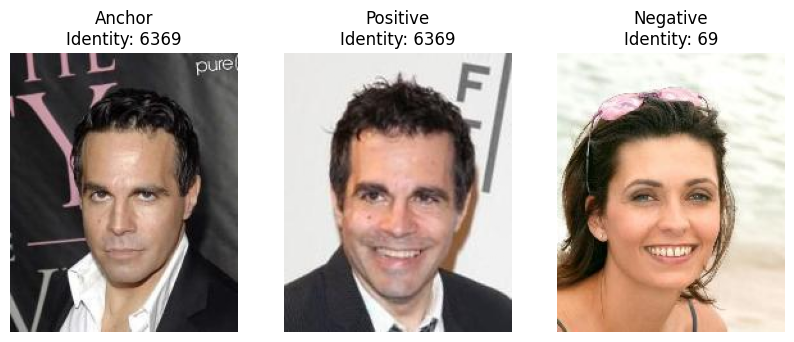

In [73]:
# A triplet batch is (Labels, Images) x (Anchor, Positive, Negative) x Batch Size x Channels x Height x Width
# = 2 x 3 x 16 x 3 x 218 x 178

def example():
    # triplet_batch = next(triplet_iter)
    # imgs = [triplet_batch[0][0][0], triplet_batch[0][1][0], triplet_batch[0][2][0]]
    # labels = [triplet_batch[1][0][0], triplet_batch[1][1][0], triplet_batch[1][2][0]]
    # plot_triplet(imgs, labels)

    idx = triplet_sampler[next(example_iter)]
    triplet_batch = triplet_dataset.__getitem__(idx)
    print("Triplet Batch size:")
    print(len(triplet_batch), len(triplet_batch[0]), "16", len(triplet_batch[0][0]), *triplet_batch[0][0][0].shape, sep=' x ')
    plot_triplet(triplet_batch[0], triplet_batch[1])
    
example()

In [78]:
class TripletNet(nn.Module):
    def __init__(self):
        super(TripletNet, self).__init__()
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.resnet.fc = nn.Identity() # Override last layer with no impl 
        self.fc = nn.Linear(512, 1000) # Input features is 512 and output layers correspond to number of classes in ResNet, i.e. 1000 

    def forward(self, anchor, positive, negative):
        anchor = self.resnet(anchor)
        anchor = self.fc(anchor)
        positive = self.resnet(positive)
        positive = self.fc(positive)
        negative = self.resnet(negative)
        negative = self.fc(negative)
        return anchor, positive, negative


def train_triplet_net(triplet_net, triplet_data_loader, epochs=1, lr=0.001, freeze=False):
    if freeze:
        # freeze all layers except the last fc layer
        for param in triplet_net.resnet.parameters():
            param.requires_grad = False
        triplet_net.fc.requires_grad = True
    
    triplet_net.train()
    optimizer = optim.Adam(triplet_net.parameters(), lr=lr)
    criterion = nn.TripletMarginLoss(margin=1.0, p=2)
    for epoch in range(epochs):
        running_loss = 0.0
        for i, triplet_batch in enumerate(triplet_data_loader):
            optimizer.zero_grad()
            anchor, positive, negative = triplet_batch[0]
            anchor, positive, negative = anchor.cuda(), positive.cuda(), negative.cuda()
            anchor, positive, negative = triplet_net(anchor, positive, negative)
            loss = criterion(anchor, positive, negative)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 1000 == 999:
                print(f"Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {running_loss / 1000}    ", end="\r")
                running_loss = 0.0
            if i == 1000:
                break
        
    print("Finished Training\n")


def test_triplet_net(triplet_net, triplet_data_loader):
    triplet_net.eval()
    with torch.no_grad():
        for i, triplet_batch in enumerate(triplet_data_loader):
            anchor, positive, negative = triplet_batch[0]
            anchor, positive, negative = anchor.cuda(), positive.cuda(), negative.cuda()
            anchor, positive, negative = triplet_net(anchor, positive, negative)


triplet_net = TripletNet()
triplet_net.cuda()
train_triplet_net(triplet_net, triplet_data_loader, epochs=2, lr=0.001, freeze=True)
train_triplet_net(triplet_net, triplet_data_loader, epochs=5, lr=0.001, freeze=False)
# test_triplet_net(triplet_net, triplet_data_loader)

ValueError: high <= 0

In [ ]:
torch.save(triplet_net.state_dict(), "models/triplet_net.pt")

In [ ]:
triplet_net = TripletNet()
triplet_net.load_state_dict(torch.load("models/triplet_net.pt"))
triplet_net.cuda()

### Plots

In [ ]:
# Show the embeddings of the all images of the first 10 people

# get all images of the first 10 people
first_10_idx = torch.where(celeba_train.identity <= 10)[0]

# get all embeddings of triplet_net of the first 10 people
first_10_embeddings = []
# first_10_imgs = []
for i in first_10_idx:
    img, label = celeba_train[i]
    # first_10_imgs.append(img)
    img = img.cuda()
    img = img.unsqueeze(0)
    embedding = triplet_net.resnet(img)
    first_10_embeddings.append(embedding)

first_10_labels = celeba_train.identity[first_10_idx].numpy()

# find first image of each of the first 10 people
first_10_imgs = []
for i in range(1,11):
    idx = torch.where(celeba_train.identity == i)[0][0]
    img, label = celeba_train[idx]
    first_10_imgs.append(img)

# show one image of each of the first 10 people
fig, ax = plt.subplots(1, 10, figsize=(20, 20))
for i, img in enumerate(first_10_imgs):
    ax[i].imshow(img.permute(1, 2, 0))
    ax[i].set_title(f"Identity: {i + 1}")
    ax[i].axis('off')
plt.show()

# plot the embeddings of the first 10 people
first_10_embeddings = torch.stack(first_10_embeddings)
first_10_embeddings = first_10_embeddings.squeeze(1)
first_10_embeddings = first_10_embeddings.cpu().detach().numpy()
plt.scatter(first_10_embeddings[:, 0], first_10_embeddings[:, 1], c=first_10_labels)
plt.show()

# print identity with lowest and largest embedding value
max_idx = np.argmax(first_10_embeddings[:, 0])
print("Identity with largest embedding value:")
print(first_10_labels[max_idx])
min_idx = np.argmin(first_10_embeddings[:, 0])
print("Identity with lowest embedding value:")
print(first_10_labels[min_idx])

# Show the embeddings of the first 10 people with TSNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
first_10_embeddings_tsne = tsne.fit_transform(first_10_embeddings)
# show legend with 10 identities
plt.legend([f"Identity: {i + 1}" for i in range(10)])
plt.scatter(first_10_embeddings_tsne[:, 0], first_10_embeddings_tsne[:, 1], c=first_10_labels, cmap='tab10')
plt.show()

# print identity with lowest and largest TNES value
max_idx = np.argmax(first_10_embeddings_tsne[:, 0])
print("Identity with largest TNES value:")
print(first_10_labels[max_idx])
min_idx = np.argmin(first_10_embeddings_tsne[:, 0])
print("Identity with lowest TNES value:")
print(first_10_labels[min_idx])


### 3.5 Training function (fit) (PROVIDED BY HENRIK)
The code below can be used to train a model and monitor important stats as training progresses. The training is carried out by calling the `fit` function, which takes any model as input.

You can change the optimizer by replacing `base_optimizer` with your own function handle.

The function `base_lr_scheduler` is a learning rate scheduler that updates the learning rate of the optimizer during training. The dummy-implementation does nothing, but you can modify it to implement your own learning rate scheduler. The inputs are
- `T` : Total number of batches
- `t` : Current batch index (max(t) = T)
- `lr` : Current learning rate

Other parameters to `fit` are:
- `bs` the batch size
- `epochs` the number of epochs
- `batches_per_epoch` the number of batches per epoch. If set to `None`, all images in the dataset are used.

Note that you can use `batches_per_epoch` to reduce the size of the training set. The effective size of the training set is `bs*batches_per_epoch`.

In [ ]:
from torch import optim

# Function handle that returns an optimizer
def base_optimizer(model,lr=0.001, momentum=0.9):
    return optim.SGD(model.parameters(), lr=lr,momentum=momentum)

# Function handle that updates the learning rate
# (note this is a dummy implementation that does nothing)
def base_lr_scheduler(t,T,lr):
  return lr

# Function to fit a model
def fit(model,
        opt_func=base_optimizer, # Inject own optimizer here
        lr_scheduler=base_lr_scheduler, # Inject own scheduler here
        bs=256,
        epochs=1,
        batches_per_epoch=None, # Default: Use entire training set
        show_summary=True):

  # Set up data loaders
  if batches_per_epoch == None:
    # Use all images
    train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=2)
    valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=2)
    batches_per_epoch = len(train_dl)
  else:
    # Only use a subset of the data
    subset_indices = list(range(batches_per_epoch*bs))
    train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=2)

    # Use one fourth for validation
    subset_indices = list(range(int(np.ceil(batches_per_epoch/4))*bs))
    valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=2)

  # Initialize optimizer
  opt = opt_func(model)

  # For book keeping
  train_loss_history = []
  valid_loss_history = []
  plot_time_train = []
  plot_time_valid = []

  # Index of current batch
  t = 1

  # Total number of batches
  T = batches_per_epoch * epochs

  print('Epochs:',epochs,'Batches per epoch:',batches_per_epoch,'Total number of batches',T)

  # Get initial validation loss and accuracy
  model.eval()
  with torch.no_grad():
    valid_acc = sum(accuracy(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
    valid_loss = sum(loss_func(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
    valid_loss_history.append(valid_loss.detach().cpu().numpy())
    plot_time_valid.append(t)

  # Train
  for epoch in range(epochs):
    model.train() # Train mode
    for xb, yb in train_dl:

      # Update learning rate
      opt.param_groups[0]['lr'] = lr_scheduler(t,T,lr=opt.param_groups[0]['lr'])

      # Forward prop
      pred = model(xb.cuda())
      loss = loss_func(pred, yb.cuda())

      # Book keeping
      train_loss_history.append(loss.detach().cpu().numpy())
      plot_time_train.append(t)
      t += 1

      # Backward prop (calculate gradient)
      loss.backward()

      # Update model parameters
      opt.step()
      opt.zero_grad()

      # Validation loss and accuracy
      if t % 10 == 0:    # print every 10 mini-batches
        model.eval() # Test mode
        with torch.no_grad():
            valid_acc = sum(accuracy(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
            valid_loss = sum(loss_func(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
            valid_loss_history.append(valid_loss.detach().cpu().numpy())
            plot_time_valid.append(t-1)
            print('t',t,'lr',opt.param_groups[0]['lr'],'train loss',loss.detach().cpu().numpy(), 'val loss',valid_loss.detach().cpu().numpy(),'val accuracy', valid_acc.detach().cpu().numpy())
        model.train() # Back to train mode

  # Summary
  if show_summary:
    plt.figure()
    lines = []
    labels = []
    l, = plt.plot(plot_time_train,train_loss_history)
    lines.append(l)
    labels.append('Training')
    print(valid_loss_history)
    l, = plt.plot(plot_time_valid,valid_loss_history)
    lines.append(l)
    labels.append('Validation')
    plt.title('Loss')
    plt.legend(lines, labels, loc=(1, 0), prop=dict(size=14))
    plt.show()

  return train_loss_history



In [ ]:
# Generic function to train a model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Copy weights
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history only if in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# Generic function to display predictions for a few images
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(2, num_images//2, images_so_far)
                ax.axis('off')
                ax.set_title('pred/true: {}/{}'.format(class_names[preds[j]],
                                                       class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)